# IMA205 Challenge 2025 - Cardiac Pathology Prediction

**Nathan Rouillé**

## Preprocessing

Imports and Versions

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torchio as tio
import skimage.measure as measure
from scipy.spatial import cKDTree
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
import optuna
from functools import partial
from sklearn.preprocessing import LabelEncoder
from scipy import ndimage
np.random.seed(42)

Left ventricule segmentation

In [2]:
def process_and_save_subject(patient_dir):
    '''segment left ventricle and save new segmentation'''
    patient_id = os.path.basename(patient_dir)
    seg_ed_path = os.path.join(patient_dir, f"{patient_id}_ED_seg.nii")
    seg_es_path = os.path.join(patient_dir, f"{patient_id}_ES_seg.nii")

    seg_ed = tio.LabelMap(seg_ed_path)
    seg_es = tio.LabelMap(seg_es_path)
    seg_ed_data = seg_ed.data.numpy().astype(np.uint8)
    seg_es_data = seg_es.data.numpy().astype(np.uint8)
    
    mask_myo_ed = (seg_ed_data[0] == 2)
    filled_lv_ed = np.zeros_like(mask_myo_ed, dtype=bool)
    for z in range(mask_myo_ed.shape[-1]):
        filled_lv_ed[..., z] = ndimage.binary_fill_holes(mask_myo_ed[..., z])
    lv_mask_ed = filled_lv_ed & ~mask_myo_ed
    updated_labels_ed = seg_ed_data.copy()
    updated_labels_ed[0][lv_mask_ed] = 3

    mask_myo_es = (seg_es_data[0] == 2)
    filled_lv_es = np.zeros_like(mask_myo_es, dtype=bool)
    for z in range(mask_myo_es.shape[-1]):
        filled_lv_es[..., z] = ndimage.binary_fill_holes(mask_myo_es[..., z])
    lv_mask_es = filled_lv_es & ~mask_myo_es
    updated_labels_es = seg_es_data.copy()
    updated_labels_es[0][lv_mask_es] = 3
    
    new_seg_ed = tio.LabelMap(tensor=updated_labels_ed, affine=seg_ed.affine)
    ed_path = patient_dir + f'/{patient_id}_ED_seg_new.nii'
    new_seg_ed.save(ed_path)

    new_seg_es = tio.LabelMap(tensor=updated_labels_es, affine=seg_es.affine)
    es_path = patient_dir + f'/{patient_id}_ES_seg_new.nii'
    new_seg_es.save(es_path)

In [3]:
dataset_path = 'Dataset/Test/'
for patient_dir in [os.path.join(dataset_path, d) for d in sorted(os.listdir(dataset_path))]:
    process_and_save_subject(patient_dir)

## Feature Extraction

In [4]:
def extract_vol_features(patient_dir,Test=False):
    '''extracts 12 volume based features'''
    patient_id = os.path.basename(patient_dir)
    if Test:
        seg_ed_path = os.path.join(patient_dir, f"{patient_id}_ED_seg_new.nii")
        seg_es_path = os.path.join(patient_dir, f"{patient_id}_ES_seg_new.nii")
    else:
        seg_ed_path = os.path.join(patient_dir, f"{patient_id}_ED_seg.nii")
        seg_es_path = os.path.join(patient_dir, f"{patient_id}_ES_seg.nii")

    seg_ed = tio.LabelMap(seg_ed_path)
    seg_es = tio.LabelMap(seg_es_path)


    data_ed = seg_ed.data.numpy().squeeze()  # to get shape (H, W, D)
    data_es = seg_es.data.numpy().squeeze()
    voxel_volume_ml = np.prod(seg_ed.spacing) / 1000  # converts mm³ in ml

    def get_volume(mask, label):
        return (mask == label).sum() * voxel_volume_ml

    # Volume features at ED/ES
    lv_ed = get_volume(data_ed, 3)
    rv_ed = get_volume(data_ed, 1)
    myo_ed = get_volume(data_ed, 2)
    lv_es = get_volume(data_es, 3)
    rv_es = get_volume(data_es, 1)
    myo_es = get_volume(data_es, 2)

    # EF and ratios features
    lv_ef = ((lv_ed - lv_es) / lv_ed) if lv_ed > 0 else 0
    rv_ef = ((rv_ed - rv_es) / rv_ed) if rv_ed > 0 else 0
    ratio_rv_lv_ed = rv_ed / lv_ed if lv_ed > 0 else 0
    ratio_rv_lv_es = rv_es / lv_es if lv_es > 0 else 0
    ratio_myo_lv_ed = myo_ed / lv_ed if lv_ed > 0 else 0
    ratio_myo_lv_es = myo_es / lv_es if lv_es > 0 else 0

    return [int(patient_id), lv_ed, lv_es, rv_ed, rv_es, myo_ed, myo_es,
            lv_ef, rv_ef, ratio_rv_lv_ed, ratio_rv_lv_es, ratio_myo_lv_ed, ratio_myo_lv_es]

In [5]:
def extract_inner_outer_contours(mask_myo):
    """extracts myocarde's inner and outer contours"""

    # finds contours
    contours = measure.find_contours(mask_myo.astype(float), 0.5)

    if len(contours) == 0 or len(contours) == 1:
        return None, None

    # computes barycenter of the myocarde
    y_indices, x_indices = np.nonzero(mask_myo)
    center = np.array([np.mean(y_indices), np.mean(x_indices)])

    # for each contours compute mean distance to barycenter
    mean_distances = []
    for contour in contours:
        distances = np.linalg.norm(contour - center, axis=1)
        mean_distances.append(np.mean(distances))

    idx_endo = np.argmin(mean_distances)
    idx_epi = np.argmax(mean_distances)

    contour_endo = contours[idx_endo]
    contour_epi = contours[idx_epi]

    return contour_endo, contour_epi

def compute_wall_thickness_features_from_mask(mask_myo, spacing=(1.0, 1.0)):
    """computes myocarde thickness features for a segmentation"""

    contour_endo, contour_epi = extract_inner_outer_contours(mask_myo)

    if contour_endo is None or contour_epi is None:
        return None, None

    # real world coordinates
    dx, dy = spacing
    contour_endo = contour_endo * np.array([dy, dx])
    contour_epi = contour_epi * np.array([dy, dx])

    # finds thickness with shortest distance between inner and outer contours in each point
    kdtree = cKDTree(contour_epi)
    distances, _ = kdtree.query(contour_endo)

    thickness_mean = np.mean(distances)
    thickness_std = np.std(distances)

    return thickness_mean, thickness_std

def compute_thickness_features(volume_masks_myo, spacing=(1.0, 1.0, 1.0)):
    """computes myocarde thickness features for 3D segmentations"""
    profile_means = []
    profile_stds = []
    slice_spacing = spacing[:2]
    for i in range(volume_masks_myo.shape[2]):
        mask_myo = volume_masks_myo[:, :, i]
        if mask_myo.sum() == 0:
            continue
        thickness_mean, thickness_std = compute_wall_thickness_features_from_mask(mask_myo, slice_spacing)
        if thickness_mean == None or thickness_std == None:
            continue
        profile_means.append(thickness_mean)
        profile_stds.append(thickness_std)
    
    if not profile_means or not profile_stds:
        return (0.0, 0.0, 0.0, 0.0)

    profile_means = np.array(profile_means)
    profile_stds = np.array(profile_stds)
    thickness_max_mean = np.max(profile_means)
    thickness_std_mean = np.std(profile_means)
    thickness_mean_std = np.mean(profile_stds)
    thickness_std_std = np.std(profile_stds)

    return thickness_max_mean, thickness_std_mean, thickness_mean_std, thickness_std_std

Create and save features

In [6]:
dataset_path = "Dataset/Train/"
results = []
for patient_dir in [os.path.join(dataset_path, d) for d in sorted(os.listdir(dataset_path))]:
    patient_id = os.path.basename(patient_dir)

    vol_features = extract_vol_features(patient_dir)

    seg_ed_path = os.path.join(patient_dir, f"{patient_id}_ED_seg.nii")
    seg_es_path = os.path.join(patient_dir, f"{patient_id}_ES_seg.nii")
    myo_ed = tio.LabelMap(seg_ed_path)
    myo_es = tio.LabelMap(seg_es_path)
    spacing_ed = myo_ed.spacing
    spacing_es = myo_es.spacing
    myo_ed = myo_ed.data.numpy().astype(np.uint8).squeeze() == 2
    myo_es = myo_es.data.numpy().astype(np.uint8).squeeze() == 2
    thickness_max_mean_ed, thickness_std_mean_ed, thickness_mean_std_ed, thickness_std_std_ed = compute_thickness_features(myo_ed, spacing_ed)
    thickness_max_mean_es, thickness_std_mean_es, thickness_mean_std_es, thickness_std_std_es = compute_thickness_features(myo_es, spacing_es)
    results.append(vol_features + [thickness_max_mean_ed, thickness_std_mean_ed, thickness_mean_std_ed, thickness_std_std_ed,
                    thickness_max_mean_es, thickness_std_mean_es, thickness_mean_std_es, thickness_std_std_es])
    
# Export CSV
columns = ["Id","LV_ED_vol", "LV_ES_vol", "RV_ED_vol", "RV_ES_vol", 
           "Myo_ED_vol", "Myo_ES_vol", "LV_EF", "RV_EF", 
           "RV_LV_ratio_ED", "RV_LV_ratio_ES", "Myo_LV_ratio_ED", "Myo_LV_ratio_ES","thickness_max_mean_ED", 
           "thickness_std_mean_ED", "thickness_mean_std_ED", "thickness_std_std_ED",
           "thickness_max_mean_ES", "thickness_std_mean_ES", "thickness_mean_std_ES", "thickness_std_std_ES"]
df_train_20_features = pd.DataFrame(results, columns=columns)
df_train_metadata = pd.read_csv("Dataset/metaDataTrain.csv")
df_train = df_train_20_features.merge(df_train_metadata, on="Id", how="left")
df_train.to_csv("data_train.csv", index=False)
    

In [7]:
dataset_path = "Dataset/Test/"
results = []
for patient_dir in [os.path.join(dataset_path, d) for d in sorted(os.listdir(dataset_path))]:
    patient_id = os.path.basename(patient_dir)

    vol_features = extract_vol_features(patient_dir, Test=True)

    seg_ed_path = os.path.join(patient_dir, f"{patient_id}_ED_seg_new.nii")
    seg_es_path = os.path.join(patient_dir, f"{patient_id}_ES_seg_new.nii")
    myo_ed = tio.LabelMap(seg_ed_path)
    myo_es = tio.LabelMap(seg_es_path)
    spacing_ed = myo_ed.spacing
    spacing_es = myo_es.spacing
    myo_ed = myo_ed.data.numpy().astype(np.uint8).squeeze() == 2
    myo_es = myo_es.data.numpy().astype(np.uint8).squeeze() == 2
    thickness_max_mean_ed, thickness_std_mean_ed, thickness_mean_std_ed, thickness_std_std_ed = compute_thickness_features(myo_ed, spacing_ed)
    thickness_max_mean_es, thickness_std_mean_es, thickness_mean_std_es, thickness_std_std_es = compute_thickness_features(myo_es, spacing_es)
    results.append(vol_features + [thickness_max_mean_ed, thickness_std_mean_ed, thickness_mean_std_ed, thickness_std_std_ed,
                    thickness_max_mean_es, thickness_std_mean_es, thickness_mean_std_es, thickness_std_std_es])


columns = ["Id","LV_ED_vol", "LV_ES_vol", "RV_ED_vol", "RV_ES_vol", 
           "Myo_ED_vol", "Myo_ES_vol", "LV_EF", "RV_EF", 
           "RV_LV_ratio_ED", "RV_LV_ratio_ES", "Myo_LV_ratio_ED", "Myo_LV_ratio_ES","thickness_max_mean_ED", 
           "thickness_std_mean_ED", "thickness_mean_std_ED", "thickness_std_std_ED",
           "thickness_max_mean_ES", "thickness_std_mean_ES", "thickness_mean_std_ES", "thickness_std_std_ES"]
df_test_20_features = pd.DataFrame(results, columns=columns)
df_test_metadata = pd.read_csv("Dataset/metaDataTest.csv")
df_test = df_train_20_features.merge(df_test_metadata, on="Id", how="left")
df_test.to_csv("data_test.csv", index=False)
    

## Methodology

In [ ]:
# Load Data
df_train = pd.read_csv("data_train.csv")
df_test = pd.read_csv("data_test.csv")

X_train = df_train.drop(columns=["Id", "Category"])
y_train = df_train["Category"]
X_test = df_test.drop(columns=["Id"])

Nested cross validation

In [9]:
# models pipeline and hyperparameters
models = {
    'SVC': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('model', SVC(probability=True, random_state=42))
        ]),
        'params': {
            'model__C': [0.06, 0.08, 0.1, 0.12, 0.14],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        }
    },
    'LogisticRegression': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        'params': {
            'model__C': [0.1,0.5,1,4,10],
            'model__penalty': ['l2']
        }
    },
    'RandomForest': {
        'pipeline': Pipeline([
            ('model', RandomForestClassifier(random_state=42))
        ]),
        'params': {
            'model__n_estimators': [650, 700, 750, 800, 850, 900, 1000],
            'model__max_depth': [None],
            'model__bootstrap': [True]
        }
    },
    'XGBoost': {
        'pipeline': Pipeline([
            ('model', XGBClassifier(eval_metric='logloss', enable_categorical=False, random_state=42))
        ]),
        'params': {
            'model__max_depth': [None, 2, 3],
            'model__learning_rate': [0.01, 0.05, 0.1, 0.15]
        }
    },
    'LightGBM': {
        'pipeline': Pipeline([
            ('model', LGBMClassifier(verbose=-1, force_col_wise=True, random_state=42))
        ]),
        'params': {
            'model__num_leaves': [None],
            'model__learning_rate': [0.01, 0.03, 0.05, 0.07],
            'model__min_data_in_leaf': [4, 5, 6]
        }
    },
    'MLP': {
        'pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('model', MLPClassifier(max_iter=500, random_state=42))
        ]),
        'params': {
            'model__hidden_layer_sizes': [(100,100), (110,110), (90,90), (90,110), (110,90), (80,80)],
            'model__activation': ['logistic'],
            'model__alpha': [0.005, 0.008, 0.01, 0.05, 0.07],
            'model__learning_rate_init': [0.01, 0.015, 0.02],
            'model__batch_size': [4, 8, 12, 16],
            'model__early_stopping': [True]
        }
    },
    'NaiveBayes': {
        'pipeline': Pipeline([
            ('model', GaussianNB())
        ]),
        'params': {
            'model__var_smoothing': [8e-10, 1e-9, 1.2e-9]
        }
    }
}

# Nested cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

models_eval = []
models_preds = {}
params_models = {}


for name, config in models.items():
    print(f"\nOptimisation de {name}")
    
    gs = GridSearchCV(
        estimator=config['pipeline'],
        param_grid=config['params'],
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    models_preds[name] = np.empty_like(y_train)
    params_models[name] = []
    outer_scores = []
    
    for train_idx, val_idx in outer_cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        gs.fit(X_tr, y_tr)
        best_pipeline = gs.best_estimator_
        score = accuracy_score(y_val, best_pipeline.predict(X_val))
        outer_scores.append(score)
        models_preds[name][val_idx] = best_pipeline.predict(X_val)
        params_models[name].append(gs.best_params_)
    
    mean_score = np.mean(outer_scores)
    print(f"{name} - Accuracy moyenne: {mean_score:.3f}")
    models_eval.append((name, mean_score, gs.best_estimator_))


Optimisation de SVC
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
SVC - Accuracy moyenne: 0.950

Optimisation de LogisticRegression
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
LogisticRegression - Accuracy moyenne: 0.930

Optimisation de RandomForest
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 7 candidates, totalling 2


Meilleur modèle: RandomForest avec une précision de 0.960 et des paramètres {'memory': None, 'steps': [('model', RandomForestClassifier(n_estimators=800, random_state=42))], 'transform_input': None, 'verbose': False, 'model': RandomForestClassifier(n_estimators=800, random_state=42), 'model__bootstrap': True, 'model__ccp_alpha': 0.0, 'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__max_leaf_nodes': None, 'model__max_samples': None, 'model__min_impurity_decrease': 0.0, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__min_weight_fraction_leaf': 0.0, 'model__monotonic_cst': None, 'model__n_estimators': 800, 'model__n_jobs': None, 'model__oob_score': False, 'model__random_state': 42, 'model__verbose': 0, 'model__warm_start': False}


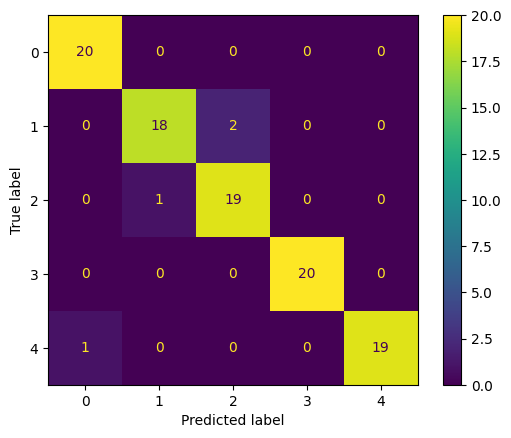

In [10]:
best_model = max(models_eval, key=lambda x: x[1])
print(f"\nMeilleur modèle: {best_model[0]} avec une précision de {best_model[1]:.3f} et des paramètres {best_model[2].get_params()}")
conf_mat = confusion_matrix(y_train, models_preds[best_model[0]])
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

Best Model (Random Forest) refined optimization and feature selection

In [11]:
def objective(trial, X, y,cv=3, random_state=42):

    params = {
        'n_estimators': trial.suggest_int("n_estimators", 500, 1000),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.05, 0.2),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'selector_threshold': trial.suggest_float("selector_threshold", 1e-5, 0.1, log=True),
        'selector_max_features': trial.suggest_int("selector_max_features", 6, 22)
    }
    model = create_rf_pipeline(params)
    score = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state), scoring="accuracy").mean()
    return score


def create_rf_pipeline(params):
    """Crée une nouvelle instance vierge du pipeline avec les paramètres donnés"""
    base_rf = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        min_samples_split=params['min_samples_split'],
        criterion=params['criterion'],
        max_depth=None,
        bootstrap=True,
        random_state=42
    )
    
    return Pipeline([
        ('selector', SelectFromModel(
            estimator=clone(base_rf),  # independant instance
            threshold=params['selector_threshold'],
            max_features=params['selector_max_features']
        )),
        ('classifier', clone(base_rf))  # new independant instance
    ])


outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


best_params = []
val_preds = np.empty_like(y_train)

for fold_idx, (train_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train)):
    print(f'Fold {fold_idx + 1}/{outer_cv.n_splits}')
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
 
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(partial(objective, X=X_tr, y=y_tr), n_trials=10)
    

    fold_best_params = study.best_params
    best_params.append(fold_best_params)
    

    best_model = create_rf_pipeline(fold_best_params)
    best_model.fit(X_tr, y_tr)
    

    val_preds[val_idx] = best_model.predict(X_val)

[I 2025-05-04 23:33:06,225] A new study created in memory with name: no-name-16ade7e4-aa1b-47a1-b495-636bdeafde4f


Fold 1/5


[I 2025-05-04 23:33:17,331] Trial 0 finished with value: 0.9012345679012346 and parameters: {'n_estimators': 687, 'min_samples_split': 0.19260714596148742, 'criterion': 'gini', 'selector_threshold': 4.207988669606632e-05, 'selector_max_features': 8}. Best is trial 0 with value: 0.9012345679012346.
[I 2025-05-04 23:33:22,357] Trial 1 finished with value: 0.9382716049382717 and parameters: {'n_estimators': 529, 'min_samples_split': 0.1799264218662403, 'criterion': 'entropy', 'selector_threshold': 1.2087541473056957e-05, 'selector_max_features': 22}. Best is trial 1 with value: 0.9382716049382717.
[I 2025-05-04 23:33:31,856] Trial 2 finished with value: 0.9259259259259259 and parameters: {'n_estimators': 917, 'min_samples_split': 0.08185086660174143, 'criterion': 'entropy', 'selector_threshold': 0.00016480446427978953, 'selector_max_features': 14}. Best is trial 1 with value: 0.9382716049382717.
[I 2025-05-04 23:33:37,919] Trial 3 finished with value: 0.9135802469135802 and parameters: {'

Fold 2/5


[I 2025-05-04 23:34:18,262] Trial 0 finished with value: 0.9131054131054132 and parameters: {'n_estimators': 687, 'min_samples_split': 0.19260714596148742, 'criterion': 'gini', 'selector_threshold': 4.207988669606632e-05, 'selector_max_features': 8}. Best is trial 0 with value: 0.9131054131054132.
[I 2025-05-04 23:34:22,535] Trial 1 finished with value: 0.9629629629629629 and parameters: {'n_estimators': 529, 'min_samples_split': 0.1799264218662403, 'criterion': 'entropy', 'selector_threshold': 1.2087541473056957e-05, 'selector_max_features': 22}. Best is trial 1 with value: 0.9629629629629629.
[I 2025-05-04 23:34:30,110] Trial 2 finished with value: 0.9506172839506172 and parameters: {'n_estimators': 917, 'min_samples_split': 0.08185086660174143, 'criterion': 'entropy', 'selector_threshold': 0.00016480446427978953, 'selector_max_features': 14}. Best is trial 1 with value: 0.9629629629629629.
[I 2025-05-04 23:34:36,041] Trial 3 finished with value: 0.9506172839506174 and parameters: {'

Fold 3/5


[I 2025-05-04 23:35:28,736] Trial 0 finished with value: 0.9254510921177589 and parameters: {'n_estimators': 687, 'min_samples_split': 0.19260714596148742, 'criterion': 'gini', 'selector_threshold': 4.207988669606632e-05, 'selector_max_features': 8}. Best is trial 0 with value: 0.9254510921177589.
[I 2025-05-04 23:35:39,179] Trial 1 finished with value: 0.9254510921177589 and parameters: {'n_estimators': 529, 'min_samples_split': 0.1799264218662403, 'criterion': 'entropy', 'selector_threshold': 1.2087541473056957e-05, 'selector_max_features': 22}. Best is trial 0 with value: 0.9254510921177589.
[I 2025-05-04 23:35:52,718] Trial 2 finished with value: 0.9254510921177589 and parameters: {'n_estimators': 917, 'min_samples_split': 0.08185086660174143, 'criterion': 'entropy', 'selector_threshold': 0.00016480446427978953, 'selector_max_features': 14}. Best is trial 0 with value: 0.9254510921177589.
[I 2025-05-04 23:35:59,547] Trial 3 finished with value: 0.9254510921177589 and parameters: {'

Fold 4/5


[I 2025-05-04 23:36:45,305] Trial 0 finished with value: 0.9007597340930674 and parameters: {'n_estimators': 687, 'min_samples_split': 0.19260714596148742, 'criterion': 'gini', 'selector_threshold': 4.207988669606632e-05, 'selector_max_features': 8}. Best is trial 0 with value: 0.9007597340930674.
[I 2025-05-04 23:36:50,034] Trial 1 finished with value: 0.9629629629629629 and parameters: {'n_estimators': 529, 'min_samples_split': 0.1799264218662403, 'criterion': 'entropy', 'selector_threshold': 1.2087541473056957e-05, 'selector_max_features': 22}. Best is trial 1 with value: 0.9629629629629629.
[I 2025-05-04 23:36:58,391] Trial 2 finished with value: 0.9506172839506174 and parameters: {'n_estimators': 917, 'min_samples_split': 0.08185086660174143, 'criterion': 'entropy', 'selector_threshold': 0.00016480446427978953, 'selector_max_features': 14}. Best is trial 1 with value: 0.9629629629629629.
[I 2025-05-04 23:37:04,663] Trial 3 finished with value: 0.9377967711301044 and parameters: {'

Fold 5/5


[I 2025-05-04 23:38:14,859] Trial 0 finished with value: 0.8869895536562203 and parameters: {'n_estimators': 687, 'min_samples_split': 0.19260714596148742, 'criterion': 'gini', 'selector_threshold': 4.207988669606632e-05, 'selector_max_features': 8}. Best is trial 0 with value: 0.8869895536562203.
[I 2025-05-04 23:38:22,048] Trial 1 finished with value: 0.9629629629629629 and parameters: {'n_estimators': 529, 'min_samples_split': 0.1799264218662403, 'criterion': 'entropy', 'selector_threshold': 1.2087541473056957e-05, 'selector_max_features': 22}. Best is trial 1 with value: 0.9629629629629629.
[I 2025-05-04 23:38:30,407] Trial 2 finished with value: 0.9753086419753085 and parameters: {'n_estimators': 917, 'min_samples_split': 0.08185086660174143, 'criterion': 'entropy', 'selector_threshold': 0.00016480446427978953, 'selector_max_features': 14}. Best is trial 2 with value: 0.9753086419753085.
[I 2025-05-04 23:38:36,632] Trial 3 finished with value: 0.949667616334283 and parameters: {'n

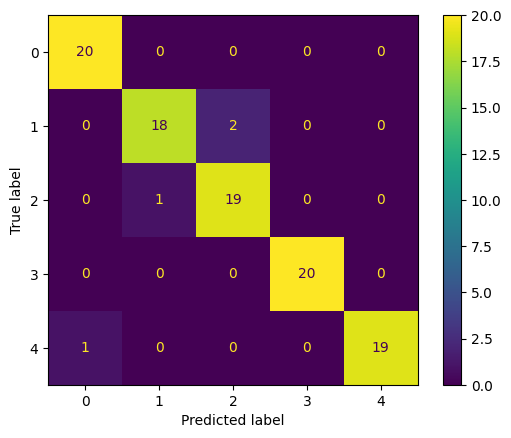

In [12]:
conf_mat = confusion_matrix(y_train, val_preds)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

As we can see, we have the same confusion matrix as the previous simpler Random Forest Model. There is no need of further optimization or feature selection, we will keep the previous model.

Two-Stage Classification Refinement

In [13]:
# Class 1 and 2 filtering
train_mask = np.isin(y_train, [1, 2])
X_train_1_2 = X_train[train_mask]
y_train_1_2 = y_train[train_mask]
le = LabelEncoder()
y_train_1_2_encoded = le.fit_transform(y_train_1_2) # XGBoost needs 0-1 encoding

# Nested cross-validation
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_models = []
for name, config in models.items():

    print(f"\nOptimisation {name}")
    gs = GridSearchCV(
        config['pipeline'],
        config['params'],
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )
    gs.fit(X_train_1_2, y_train_1_2_encoded)
    final_model = gs.best_estimator_
    
    # outer cross-validation
    outer_scores = []
    for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_1_2, y_train_1_2_encoded)):
        X_tr, X_val = X_train_1_2.iloc[train_idx], X_train_1_2.iloc[val_idx]
        y_tr, y_val = y_train_1_2_encoded[train_idx], y_train_1_2_encoded[val_idx]
        
        gs.fit(X_tr, y_tr)
        score = gs.score(X_val, y_val)
        outer_scores.append(score)
    
    mean_score = np.mean(outer_scores)
    print(f"{name} - mean accuracy: {mean_score:.3f}")
    best_models.append((name, mean_score, gs.best_estimator_))

# Best model selection
best_model_name, best_score, best_estimator = max(best_models, key=lambda x: x[1])
print(f"\nBest Model: {best_model_name} (Accuracy: {best_score:.3f})")


Optimisation SVC
SVC - mean accuracy: 0.976

Optimisation LogisticRegression
LogisticRegression - mean accuracy: 0.951

Optimisation RandomForest
RandomForest - mean accuracy: 0.901

Optimisation XGBoost
XGBoost - mean accuracy: 0.901

Optimisation LightGBM
LightGBM - mean accuracy: 0.877

Optimisation MLP
MLP - mean accuracy: 0.925

Optimisation NaiveBayes
NaiveBayes - mean accuracy: 0.901

Best Model: SVC (Accuracy: 0.976)


First try with previous best model (SVC)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
NaiveBayes - mean accuracy: 0.970


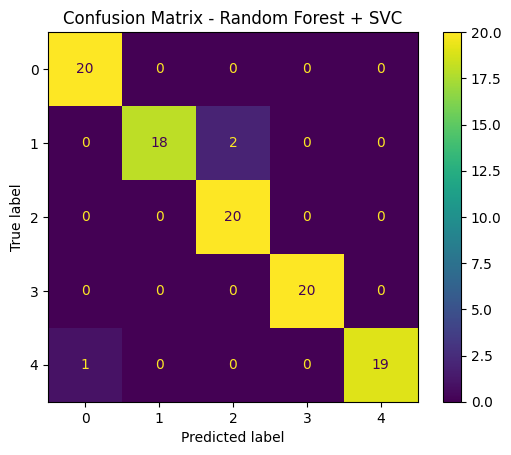

In [14]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

models_eval = []
models_preds = {}
params_models = {}

gs = GridSearchCV(
    estimator=models['RandomForest']['pipeline'],
    param_grid=models['RandomForest']['params'],
    cv=inner_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

final_search = GridSearchCV(
    estimator=models['SVC']['pipeline'],
    param_grid=models['SVC']['params'],
    cv=inner_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

model_preds = np.empty_like(y_train)
outer_scores = []

for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    X_val_4_features = X_val
    X_tr_4_features = X_tr
    tr_mask = np.isin(y_tr, [1, 2])
    X_tr_1_2 = X_tr_4_features[tr_mask]
    y_tr_1_2 = y_tr[tr_mask]
    
    gs.fit(X_tr, y_tr)
    y_pred = gs.predict(X_val)
    val_mask = np.isin(y_pred, [1, 2])

    X_val_1_2 = X_val_4_features[val_mask]

    # 2nd step prediction refinement
    final_search.fit(X_tr_1_2, y_tr_1_2)
    final_model = final_search.best_estimator_
    y_pred_1_2 = final_model.predict(X_val_1_2)

    # prediction fusion
    y_pred_final = y_pred.copy()
    y_pred_final[val_mask] = y_pred_1_2
    score = accuracy_score(y_val, y_pred_final)
    outer_scores.append(score)
    model_preds[val_idx] = y_pred_final

mean_score = np.mean(outer_scores)
print(f"{name} - mean accuracy: {mean_score:.3f}")
cm = confusion_matrix(y_train, model_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix - Random Forest + SVC")
plt.show()

Second try with previous second best model (MLP)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
NaiveBayes - mean accuracy: 0.970


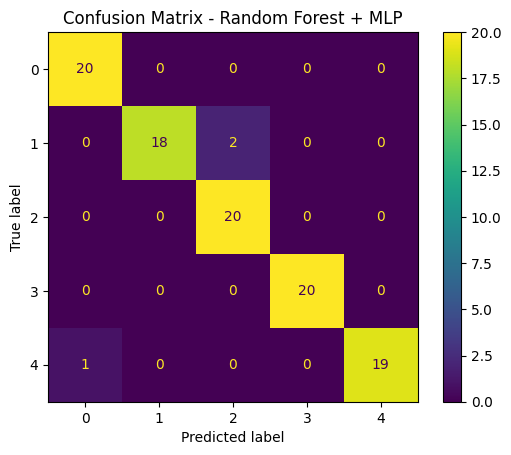

In [15]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

models_eval = []
models_preds = {}
params_models = {}

gs = GridSearchCV(
    estimator=models['RandomForest']['pipeline'],
    param_grid=models['RandomForest']['params'],
    cv=inner_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

final_search = GridSearchCV(
    estimator=models['MLP']['pipeline'],
    param_grid=models['MLP']['params'],
    cv=inner_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

model_preds = np.empty_like(y_train)
outer_scores = []

for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    X_val_4_features = X_val
    X_tr_4_features = X_tr
    tr_mask = np.isin(y_tr, [1, 2])
    X_tr_1_2 = X_tr_4_features[tr_mask]
    y_tr_1_2 = y_tr[tr_mask]
    
    gs.fit(X_tr, y_tr)
    y_pred = gs.predict(X_val)
    val_mask = np.isin(y_pred, [1, 2])

    X_val_1_2 = X_val_4_features[val_mask]

    # 2nd step prediction refinement
    final_search.fit(X_tr_1_2, y_tr_1_2)
    final_model = final_search.best_estimator_
    y_pred_1_2 = final_model.predict(X_val_1_2)

    # prediction fusion
    y_pred_final = y_pred.copy()
    y_pred_final[val_mask] = y_pred_1_2
    score = accuracy_score(y_val, y_pred_final)
    outer_scores.append(score)
    model_preds[val_idx] = y_pred_final

mean_score = np.mean(outer_scores)
print(f"{name} - mean accuracy: {mean_score:.3f}")
cm = confusion_matrix(y_train, model_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix - Random Forest + MLP")
plt.show()

Third try with meta classifier combining 2 best models (SVC + MLP)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
NaiveBayes - mean accuracy: 0.970


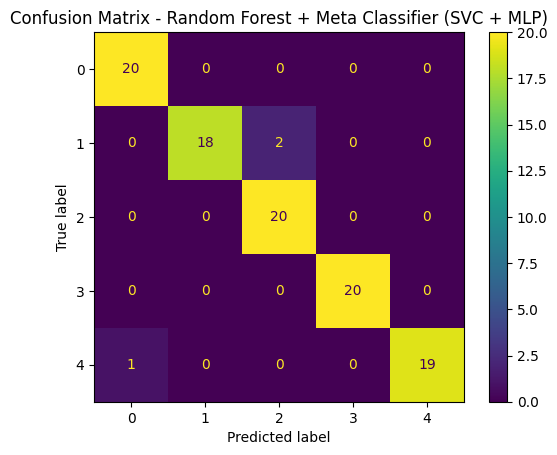

In [16]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

models_eval = []
models_preds = {}
params_models = {}

gs_rf = GridSearchCV(
    estimator=models['RandomForest']['pipeline'],
    param_grid=models['RandomForest']['params'],
    cv=inner_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

gs_svc = GridSearchCV(
    estimator=models['SVC']['pipeline'],
    param_grid=models['SVC']['params'],
    cv=inner_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

gs_mlp = GridSearchCV(
    estimator=models['MLP']['pipeline'],
    param_grid=models['MLP']['params'],
    cv=inner_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)


model_preds = np.empty_like(y_train)
outer_scores = []

for train_idx, val_idx in outer_cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    X_val_4_features = X_val
    X_tr_4_features = X_tr
    tr_mask = np.isin(y_tr, [1, 2])
    X_tr_1_2 = X_tr_4_features[tr_mask]
    y_tr_1_2 = y_tr[tr_mask]
    
    gs_rf.fit(X_tr, y_tr)
    y_pred = gs_rf.predict(X_val)
    val_mask = np.isin(y_pred, [1, 2])

    X_val_1_2 = X_val_4_features[val_mask]

    # 2nd step prediction refinement
    gs_svc.fit(X_tr_1_2, y_tr_1_2)
    final_svc = gs_svc.best_estimator_

    gs_mlp.fit(X_tr_1_2, y_tr_1_2)
    final_lr = gs_mlp.best_estimator_

    voting_clf = VotingClassifier(
        estimators=[
            ('svc', final_svc),
            ('mlp', gs_mlp)
        ],
        voting='soft',  # use probabilities for soft voting
        n_jobs=-1,
    )
    voting_clf.fit(X_tr_1_2, y_tr_1_2)
    y_pred_1_2 = voting_clf.predict(X_val_1_2)

    # prediction fusion
    y_pred_final = y_pred.copy()
    y_pred_final[val_mask] = y_pred_1_2
    score = accuracy_score(y_val, y_pred_final)
    outer_scores.append(score)
    model_preds[val_idx] = y_pred_final

mean_score = np.mean(outer_scores)
print(f"{name} - mean accuracy: {mean_score:.3f}")
cm = confusion_matrix(y_train, model_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix - Random Forest + Meta Classifier (SVC + MLP)")
plt.show()

Final prediction and submission with the best model among the last 3 try (MLP)

In [18]:

gs_rf = GridSearchCV(
    estimator=models['RandomForest']['pipeline'],
    param_grid=models['RandomForest']['params'],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

final_search_MLP = GridSearchCV(
    estimator=models['SVC']['pipeline'],
    param_grid=models['SVC']['params'],
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)


gs_rf.fit(X_train, y_train)
y_pred = gs_rf.predict(X_test)

test_mask = np.isin(y_pred, [1, 2])
X_test_1_2 = X_test[test_mask]

final_search_MLP.fit(X_train_1_2, y_train_1_2)

final_model_MLP = final_search_MLP.best_estimator_
y_pred_1_2 = final_model_MLP.predict(X_test_1_2)

# prediction fusion
y_pred_final = y_pred.copy()
y_pred_final[test_mask] = y_pred_1_2

results = pd.DataFrame({
    "Id": df_test['Id'], 
    "Category": y_pred_final
})

# Export CSV submission
results.to_csv("submission_finale.csv", index=False)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
